# Train models MDF dataset

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, KFold

import rs_models
from matplotlib import pyplot as plt
import math
from tqdm import tqdm

import implicit
from implicit.evaluation import AUC_at_k, precision_at_k, train_test_split
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix, csr_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
dataset = 'frappe'

if dataset == 'mdf':
    df = pd.read_csv('Datasets/MDF_final.csv')
    df_mf = pd.read_csv('Datasets/MDF_matrix_factorization.csv')
    df = df.drop_duplicates()
    df.user = pd.factorize(df.user)[0] # make sure that user and item IDs start from zero
    df.item = pd.factorize(df.item)[0]
    # df = df[df.item != 2]
    # df = df.drop(['place_type_food_and_drink', 'place_type_health', 'place_type_home', 'place_type_lodging','place_type_outdoors', 'place_type_point_of_interest_establishment','place_type_public_transport_station', 'place_type_school','place_type_service', 'place_type_store', 'place_type_workplace'], axis = 1)
    df.reset_index(drop=True, inplace=True)
    item_labels = [i for i in list(df.columns) if i.find("category") == 0] # labels that describe an item
    context_labels = list(set(df.iloc[:, 3:]) - set(item_labels)) # takes all the columns after user, item rating and remove item labels

elif dataset == 'frappe':
    df = pd.read_csv('Datasets/frappe dataset/frappe_final.csv')
    df_mf = pd.read_csv('Datasets/frappe dataset/frappe_matrix_factorization.csv')
    item_labels = list(df.columns[27:])
    context_labels = list(df.columns[3:27])


In [3]:
n_users = df.user.nunique()
n_items = df.item.nunique()
n_contexts = len(context_labels)

print(f"rating with value 1: {df[df.rating == 1]['rating'].count() * 100 / len(df)} %")
print(f"users: {n_users} \t items: {n_items} \t rating: {len(df)} \t items_features: {len(item_labels)} \t contexts_features: {n_contexts} \t ")

rating with value 1: 59.503414820961254 %
users: 857 	 items: 3180 	 rating: 78335 	 items_features: 53 	 contexts_features: 24 	 


In [4]:
n_splits = 2
models_eval_metrics = {}

## ALS matrix factorization

In [ ]:
accuracy, auc, precision, recall = rs_models.train_mf(df_mf, factors=256, regularization=3, iterations=10, n_splits=n_splits)
models_eval_metrics['ALS'] = [accuracy, auc, precision, recall]
print(f"NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## NeuMF

In [ ]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 256,
    'epochs': 10
}   


std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.NeuMF, param, df, n_splits=n_splits)
models_eval_metrics['NeuMF'] = [accuracy, auc, precision, recall]
print(f"NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## ECAM NeuMF

In [8]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 256,
    'epochs': 10
}  

std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.ECAM_NeuMF, param, df, context_labels=context_labels, n_splits=n_splits)
models_eval_metrics['ECAM NeuMF'] = [accuracy, auc, precision, recall]
print(f"ECAM NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

ECAM NeuMF 	 accuracy: 76.75368785858154% 	 AUC: 0.8188196122646332 	 precision: 0.7639977931976318 	 recall: 0.8817214071750641


## Classifier

In [5]:
from sklearn.model_selection import cross_validate

ffnet = KerasClassifier(build_fn=rs_models.mobile_model, neurons=100, layers=3, learn_rate=0.005, epochs=10, batch_size=64, verbose=False)
x = df[context_labels+item_labels]
y = df['rating']

scores = cross_validate(ffnet, x, y, cv=KFold(shuffle=True, n_splits=n_splits, random_state=42), scoring=['accuracy', 'roc_auc', 'precision', 'recall'])

accuracy = np.average(scores['test_accuracy'])
auc = np.average(scores['test_roc_auc'])
precision = np.average(scores['test_precision'])
recall = np.average(scores['test_recall'])
models_eval_metrics['Classifier'] = [accuracy, auc, precision, recall]

print(f"Classifier \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

Classifier 	 accuracy: 63.44417932754139% 	 AUC: 0.6303019854894414 	 precision: 0.6420488535140134 	 recall: 0.8714815354963308


## Plot Results

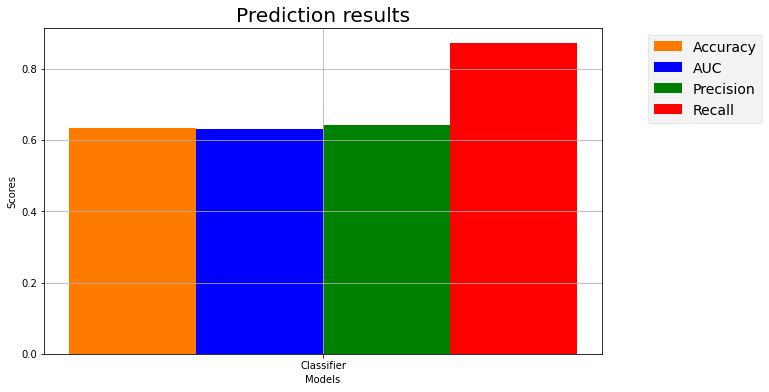

Model: Classifier Accuracy: 63.44417932754139% AUC: 0.6303019854894414 Precision: 0.6420488535140134 Recall: 0.8714815354963308


In [7]:
n_models = len(models_eval_metrics) # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 
accuracy = [x[0] for x in models_eval_metrics.values()]
auc = [x[1] for x in models_eval_metrics.values()]
precision = [x[2] for x in models_eval_metrics.values()]
recall = [x[3] for x in models_eval_metrics.values()]

index = np.arange(n_models)
bar_width = 0.15
plt.figure(figsize=(10,6))

# accuracy bar
rect1 = plt.bar(index, accuracy, bar_width, color='#ff7b00', label='Accuracy')

# AUC bar
rect2 = plt.bar(index + bar_width, auc, bar_width, color='b', label='AUC')

# precision bar
rect3 = plt.bar(index + bar_width*2, precision, bar_width, color='g', label='Precision')

# recall bar
rect4 = plt.bar(index + bar_width*3, recall, bar_width, color='r', label='Recall')

plt.style.use("fivethirtyeight")
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Prediction results')
plt.xticks(index + bar_width * 3/2, models_name) # labels position
plt.legend(bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

for key, item in models_eval_metrics.items():
    print(f'Model: {key} Accuracy: {item[0]*100}% AUC: {item[1]} Precision: {item[2]} Recall: {item[3]}')

- prendere utenti che hanno almeno un rating alterato (uno o più rating con valore 1 sono stati messi a 0 nel train set)
- per ogni utente alterato:
    - `idx` = indici nel train set per cui rating == 0, in questo modo evito di calcolare l'AUC su rating con valore 1 nel train set
    - `pred` = valori dalla matrice predicted con indici in idx
    - `actual` = valori dal test set con indici idx
    - calcolare AUC per l'utente tra actual e pred
- fare media AUC

In [6]:
ratings = coo_matrix((df_mf['rating'].astype(np.float32),
                     (df_mf['item'],
                      df_mf['user']))).tocsr()

train, test = train_test_split(ratings, train_percentage=0.80)
model = AlternatingLeastSquares(factors=256, regularization=8, iterations=10, calculate_training_loss=True)
model.fit(train, show_progress=False)

altered_users = [] # list of user that has at least one rating with value 1 hidden from the train set
train_dense = np.array(train.todense())
test_dense = np.array(test.todense())
pred_dense = np.dot(model.item_factors, model.user_factors.T)

# fill altered_user list
for user in df_mf.user.unique():
    test_user = test_dense[:, user]
    if 1 in test_user: # check if user has items altered
        altered_users.append(user)

auc = 0
        
for user in altered_users:
    train_user = train_dense[:, user] # get ratings in train set for one user
    zero_idx = np.where(train_user == 0) # find where ratings is zero
    
    # get predicted values
    user_vec = pred_dense[:, user]
    pred_user = user_vec[zero_idx]

    # get actual value in test set
    user_vec2 = test_dense[:, user]
    actual_user = user_vec2[zero_idx]
    
    auc_user = roc_auc_score(actual_user, pred_user)
    auc = auc + auc_user
    
    
print(f'AUC: {auc/len(altered_users)}')

AUC: 0.6976260091992975


In [ ]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid({'factors': [128, 256], 'regularization': [0, 3], 'iterations':[100, 200]})

for params in grid:
    model = AlternatingLeastSquares(**params)
    print(train_mf(df_mf, **params, n_splits=5), params)